<a href="https://colab.research.google.com/github/Hanzla-Nawaz/TensorFlow-Implementations/blob/main/Melanoma_Cancer_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Melanoma_Cancer Prediction**



In [ ]:
from google.colab import drive, files
import zipfile
import os

uploaded = files.upload()

# Extract the uploaded ZIP file
dataset_zip = next(iter(uploaded.keys()))
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("Dataset extracted to '/content/dataset'.")


Saving archive.zip to archive.zip
Dataset extracted to '/content/dataset'.


# **Import Libraries**

In [ ]:
import os
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Define Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-3
dataset_zip = '/content/archive.zip'
dataset_dir = '/content/dataset'
MODEL_H5_PATH = "melanoma_model.h5"
MODEL_TFLITE_PATH = "melanoma_model.tflite"

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

base_dir = os.path.join(dataset_dir, 'melanoma_cancer_dataset')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
print(f"Train Subfolders: {os.listdir(train_dir)}")
print(f"Test Subfolders: {os.listdir(test_dir)}")

assert 'benign' in os.listdir(train_dir) and 'malignant' in os.listdir(train_dir), "Train folder structure incorrect!"
assert 'benign' in os.listdir(test_dir) and 'malignant' in os.listdir(test_dir), "Test folder structure incorrect!"

Train Subfolders: ['benign', 'malignant']
Test Subfolders: ['benign', 'malignant']


## **Data Visualization**

Benign Images:


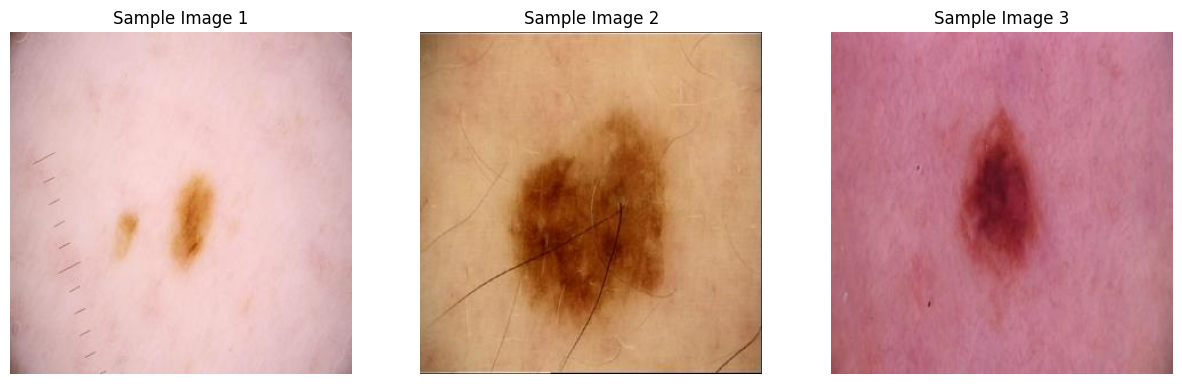

Malignant Images:


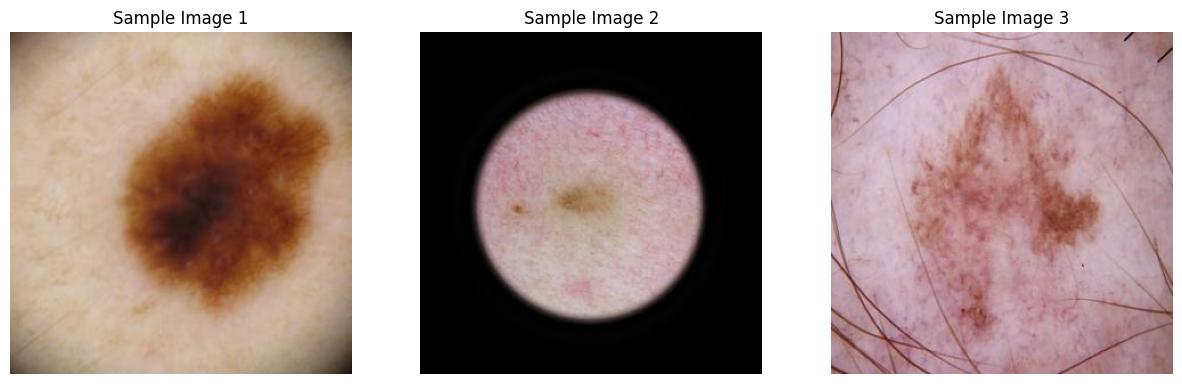

In [ ]:
def display_sample_images(image_dir, num_samples=3):
    images = []
    for i, file_name in enumerate(os.listdir(image_dir)):
        if i == num_samples:
            break
        img_path = os.path.join(image_dir, file_name)
        img = cv2.imread(img_path)
        images.append(img)

    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Sample Image {i+1}")
        plt.axis('off')
    plt.show()

# Display images
print("Benign Images:")
display_sample_images(os.path.join(train_dir, "benign"))
print("Malignant Images:")
display_sample_images(os.path.join(train_dir, "malignant"))

## **Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## **Build The Model**

In [ ]:
def create_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

## **Compute Class Weights AND Callbacks**

In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print(f"Computed Class Weights: {class_weights}")
callbacks = [
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

Computed Class Weights: {0: 0.9605, 1: 1.0428881650380022}


## **Train The Model**

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.8676 - loss: 0.3103
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 264s 594ms/step - accuracy: 0.8677 - loss: 0.3101 - val_accuracy: 0.5000 - val_loss: 1.2591 - learning_rate: 0.0010
Epoch 2/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9173 - loss: 0.2126
Epoch 2: val_accuracy improved from 0.50000 to 0.61400, saving model to best_model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 160s 412ms/step - accuracy: 0.9173 - loss: 0.2126 - val_accuracy: 0.6140 - val_loss: 1.3675 - learning_rate: 0.0010
Epoch 3/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.9340 - loss: 0.1795
Epoch 3: val_accuracy improved from 0.61400 to 0.80800, saving model to best_model.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 142s 411ms/step - accuracy: 0.9340 - loss: 0.1796 - val_accuracy: 0.8080 - val_loss: 0.4695 - learning_rate: 0.0010
Epoch 4/15
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms

## **Visualize Training History**

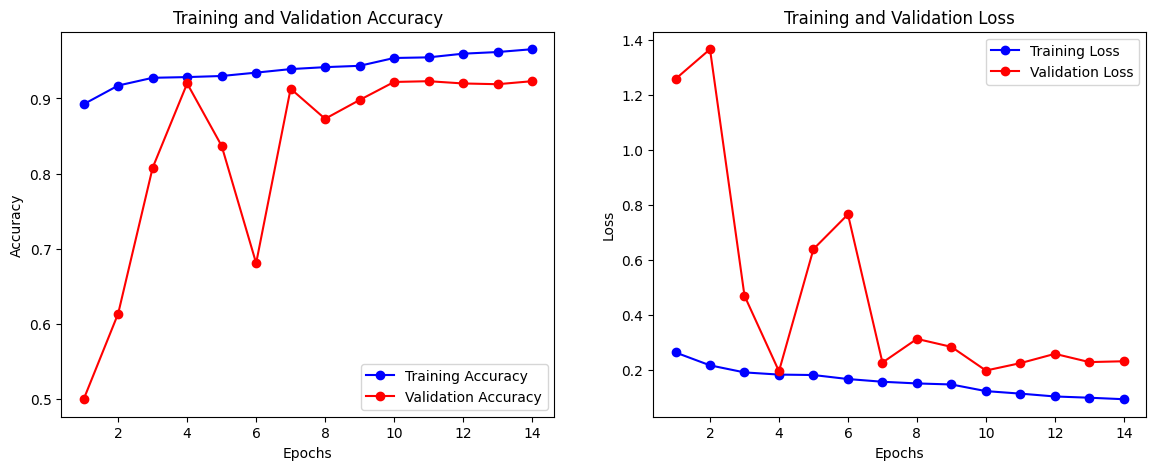

In [ ]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

## **Model Evaluation**

In [ ]:
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9185 - loss: 0.1897
Test Accuracy: 92.00%


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9087 - loss: 0.2267
Test Accuracy: 0.92
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step


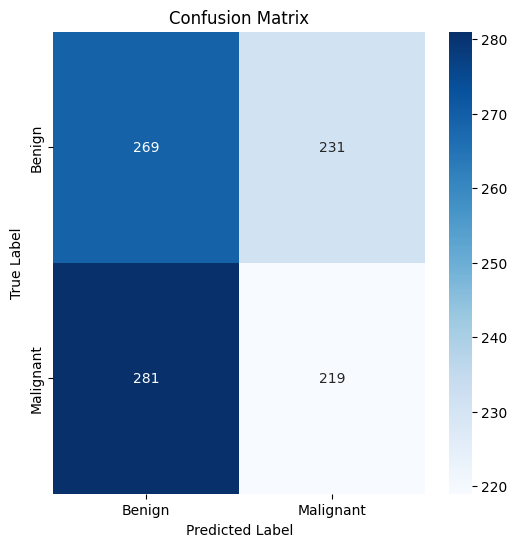

              precision    recall  f1-score   support

      Benign       0.49      0.54      0.51       500
   Malignant       0.49      0.44      0.46       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


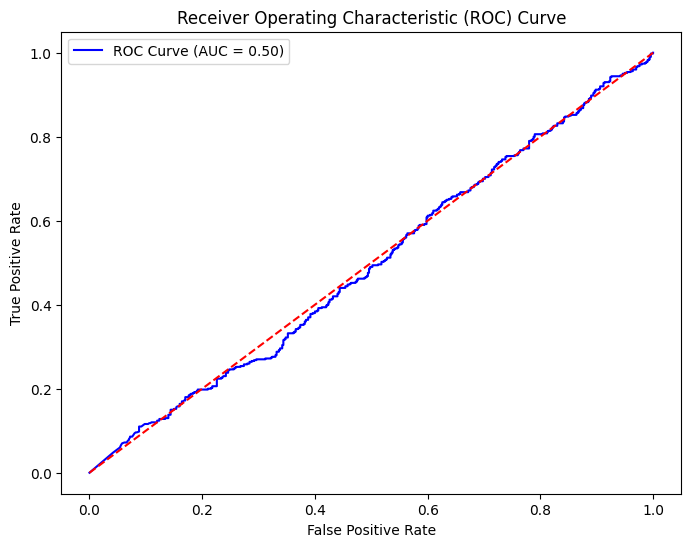

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions and metrics
y_true = val_generator.classes
y_pred = (model.predict(val_generator) > 0.5).astype("int32").flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, model.predict(val_generator))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## **Save The Model**

In [ ]:
model.save('melanoma_detection_model.h5')
print("Model saved as 'melanoma_detection_model.h5'")

Model saved as 'melanoma_detection_model.h5'


## Convert he Model to TensorFlow Lite Format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = 'melanoma_detection_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved as {tflite_model_path}")

Saved artifact at '/tmp/tmp0xqldj3_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138625559851104: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138622977488704: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138625560982656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138625555243856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138625555244560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138625555240160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138625555242448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138625555250720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138625555246320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138625555242624: TensorSpec(shape=(), dtype=tf.resource, name=

# Download The Model

In [ ]:
from google.colab import files
files.download('melanoma_detection_model.h5')
from google.colab import files
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>